# Thermal Convection (Broken)

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
boxHeight = 1000. * u.kilometer
boxLength = 2000. * u.kilometer

tempMin = 273.15 * u.degK
tempMax = 1273.15 * u.degK

KL = boxHeight
dT = (tempMax - tempMin)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[temperature]"]= dT
GEO.scaling_coefficients["[time]"] = 1.0 * u.megayear

In [4]:
GEO.scaling_coefficients

[mass],1.0 kilogram
[length],1000000.0 meter
[temperature],1000.0000000000001 kelvin
[time],31556925974700.0 second
[substance],1.0 mole


In [5]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(2000. * u.kilometer, 1000. * u .kilometer),
                  gravity=(0., -10. * u.meter / u.second**2))

## Define Material property

In [6]:
Model.density = GEO.LinearDensity(4000. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.degK)
Model.diffusivity = 1e-6 * u.metre**2 / u.second

Model.viscosity = 2.5e19 * u.pascal * u.second

The Raylegh number is defined as 

$$ Ra_0 = \frac{\alpha g \Delta T h^3}{\kappa \mu_0} $$

$\alpha$ is thermal expansion coefficient,
$\kappa$ is diffusivity,
$g$ is gravity,
$dT$ is the difference in temperature between top and bottom,
$h$ is the Model height,
$mu0$ is the kinematic viscosity.

In [7]:
alpha = Model.thermalExpansivity
kappa = Model.diffusivity
g = abs(Model.gravity[-1])
dT = dT
h = Model.height
mu0 = 2.5e19 * u.metre**2 / u.second

Ra0 = (alpha * g * dT * h**3) / (kappa * mu0)

print("Rayleigh Number:", Ra0.to_base_units())

Rayleigh Number: 10000.000000000002 dimensionless


## Define velocity boundary conditions

In [8]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], right=[0.,None], top=[None,0.], bottom=[None,0.])

## Define thermal boundary conditions

In [9]:
BoundaryBCs = Model.set_temperatureBCs(top=tempMin, bottom=tempMax)

## Define Initial Temperature perturbation

In [10]:
import math

boxLength = GEO.nd(boxLength)
boxHeight = GEO.nd(boxHeight)
tempMin = GEO.nd(tempMin)
tempMax = GEO.nd(tempMax)

Model.temperature.data[:] = 0.
pertStrength = GEO.nd(200. * u.kilometer)
deltaTemp = tempMax - tempMin

for index, coord in enumerate(Model.mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    Model.temperature.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    Model.temperature.data[index] = max(tempMin, min(tempMax, Model.temperature.data[index]))


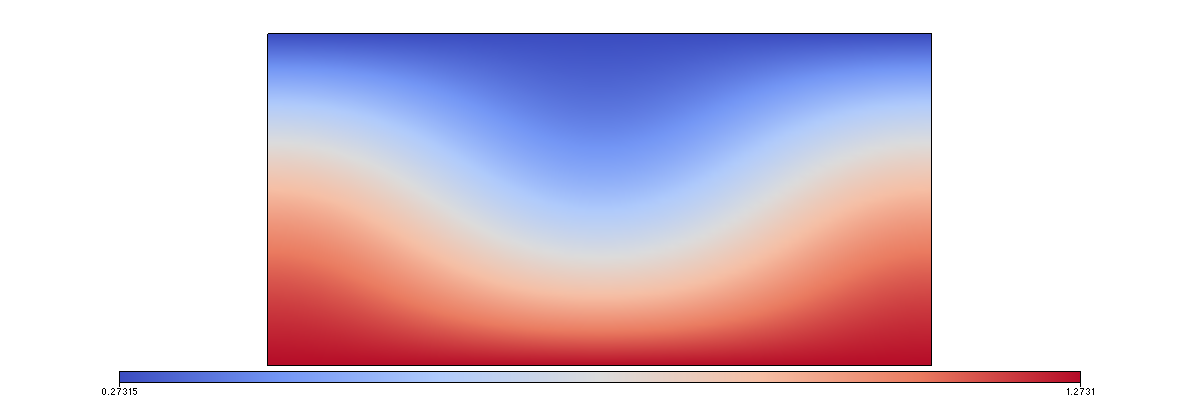

In [11]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.show()

In [12]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [13]:
Model.init_model(temperature=False)

In [ ]:
!rm -rf outputs
Model.run_for(2e-7 * u.seconds)

Running with UWGeodynamics version 0.9.4-dev-1011449(development)



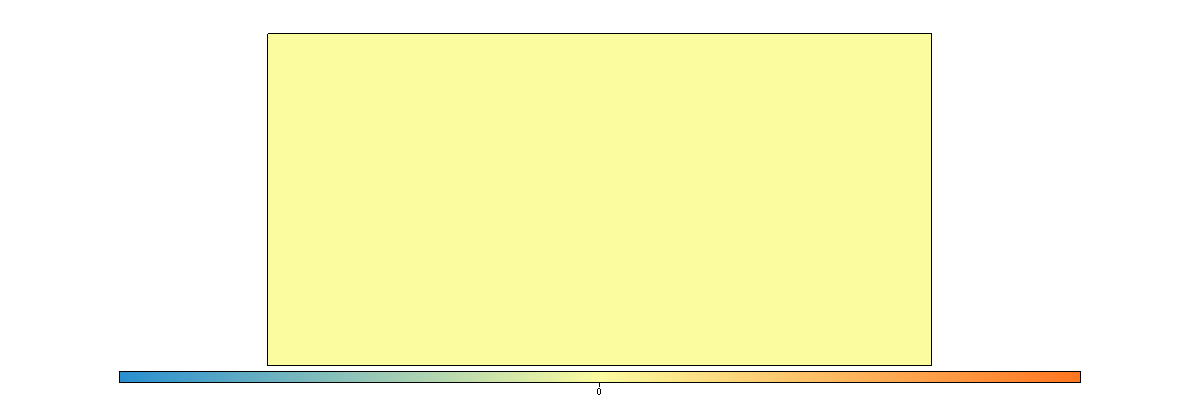

In [16]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


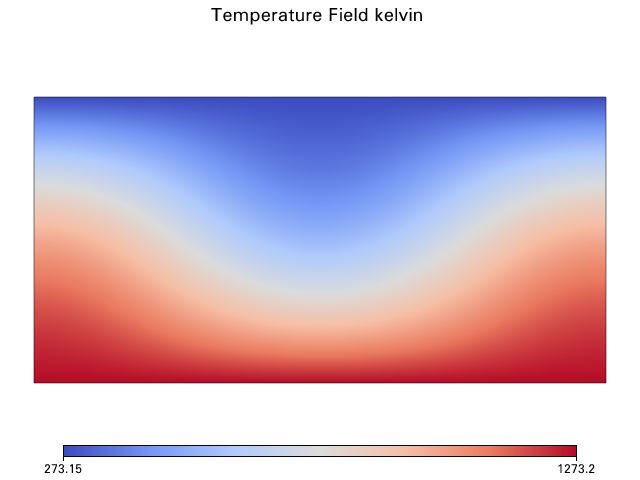

In [17]:
Fig = Model.plot.temperature()